<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Imperial_College_London_new_logo.png" alt="Imperial Logo" width="400">

### **Course:** CIVE70111 Machine Learning
### Task 2 Plant Modelling and Machine Learning Pipeline

**Project:** Plant 1 — Data Exploration, Analysis and Preprocessing

**Date:** 09/12/2025  

<p align="right">
Created by: Michael Wong

# 📘 **TABLE OF CONTENTS**

- [Project Overview](#project-overview)
- [Workflow Summary](#workflow-summary)
- [Section 1 — Imports & File Paths](#section-1--imports--file-paths)
- [Section 2 — Load & Fix Generation Data](#section-2--load--fix-generation-data)
- [Section 3 — Load & Clean Weather Data](#section-3--load--clean-weather-data)
- [Section 4 — Aggregate Inverters + Merge Weather](#section-4--aggregate-inverters--merge-weather)
- [Section 5 — Clean AC/DC Power](#section-5--clean-acdc-power)
- [Section 6 — Clean DAILY_YIELD](#section-6--clean-daily_yield)
- [Section 7 — Clean TOTAL_YIELD](#section-7--clean-total_yield)
- [Section 8 — Final Cleaned Dataset (df_ps1)](#section-8--final-cleaned-dataset-df_ps1)
- [Section 9 — Outlier Detection (Regression Residuals)](#section-9--outlier-detection-regression-residuals)
- [Section 10 — Plotting & Exploratory Data Analysis](#section-10--plotting--exploratory-data-analysis)
- [Section 11 — Example Plot Calls](#section-11--example-plot-calls)

---


# 📖 **PROJECT OVERVIEW**

This project cleans and analyzes **solar PV plant data**, consisting of two primary datasets:

---

## **1. Generation Dataset**
Includes inverter-level measurements such as:
- DC/AC power  
- Daily & total yield  
- Operating condition labels  

---

## **2. Weather Dataset**
Includes:
- Ambient temperature  
- Module temperature  
- Irradiation levels  

---

# 🎯 **Goal of the Project**

To fully **clean**, **validate**, and **visualize** inverter operational data so it can be used for:

- Machine learning models  
- Fault prediction  
- Performance assessment  
- Data quality analysis  

---

# ⚠️ **Data Quality Issues Addressed**

The cleaning pipeline resolves the following:

- Incorrect or inconsistent timestamps  
- Nighttime anomalies (e.g., positive irradiation at night)  
- Zero-power anomalies during daytime  
- Non-monotonic daily & total yields  
- Weather inconsistencies  
- Outliers in AC vs irradiation relationships  

---

# 📦 **Final Outputs**

- **`df_ps1`** → Cleaned, high-quality per-inverter dataset  
- **`df_ps1_outlier`** → Further outlier-filtered version (based on regression)  

---

# 🔄 **WORKFLOW SUMMARY**

## **STEP 1 — Import Libraries & Set Paths**
Load Python libraries, configure plotting, set dataset file paths.

---

## **STEP 2 — Load & Fix Generation Data**
- Parse timestamps using multiple formats  
- Drop invalid or corrupted rows  
- Remove unnecessary columns  
- Create inverter-specific subsets  

---

## **STEP 3 — Load & Clean Weather Data**
- Parse timestamps  
- Apply day–night logic  
- Remove incorrect nighttime irradiation  
- Create cleaned irradiation field  

---

## **STEP 4 — Aggregate Inverter Data + Merge Weather**
- Group by timestamp  
- Count optimal/suboptimal states  
- Combine with weather data  

---

## **STEP 5 — Clean AC/DC Power**
Rules applied:
- **Nighttime:** AC/DC must be zero  
- **Daytime:** Treat zeros as missing → interpolate  

---

## **STEP 6 — Clean DAILY_YIELD**
- Ensure yield is **positive**, **monotonic**, and **only increases during the day**  
- Freeze values after sunset  
- Reset to zero before sunrise  

---

## **STEP 7 — Clean TOTAL_YIELD**
- Prevent total yield from decreasing during the day  
- Reset appropriately at day boundaries  

---

## **STEP 8 — Produce Final Clean Dataset (`df_ps1`)**
- Assemble cleaned AC/DC, yields, and weather variables  
- Recalculate operating condition based on majority vote  

---

## **STEP 9 — Outlier Detection (Regression Residuals)**
- Fit linear regression using AC_CLEAN ~ IRRADIATION_CLEAN  
- Compute z-score of residuals  
- Remove statistical outliers  

---

## **STEP 10 — Plotting & EDA**
Generate plots for:

### **Raw Data**
- Generation data  
- Weather data  
- Raw inverter traces  

### **Cleaned Data**
- Cleaned time series  
- 5-day zoom views  
- Scatter plots  
- Histograms  
- Correlation matrices  
- Heatmaps  

---

## Section 1 — Imports & File Paths

This section loads all required libraries and defines the paths to the generation
and weather datasets.


In [61]:
import os
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

plt.rcParams["figure.figsize"] = (8, 4)


########################################################################################################################################################
# Change Path

folder = r"C:\Users\B.KING\OneDrive - Imperial College London\CIVE70111 Machine Learning\CouseWork\Group-11\data\In"

########################################################################################################################################################
gen_path = os.path.join(folder, "Plant_1_Generation_Data_updated.csv")
weather_path = os.path.join(folder, "Plant_1_Weather_Sensor_Data.csv")


## Section 2 — Load & Fix Generation Data

- Robustly parse DATE_TIME using two possible formats.
- Remove rows with incorrect or missing timestamps.
- Drop unused columns such as 'day'.
- Create `plant_1` dataframe and inverter dictionary `inv_1`.


In [62]:
def load_and_fix_generation(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    start = pd.Timestamp("2020-05-15")
    end = pd.Timestamp("2020-06-18")

    df["parsed"] = pd.to_datetime(
        df["DATE_TIME"], format="%Y-%m-%d %H:%M:%S", errors="coerce"
    )

    invalid = df["parsed"].isna() | (~df["parsed"].between(start, end))

    df.loc[invalid, "parsed"] = pd.to_datetime(
        df.loc[invalid, "DATE_TIME"], format="%Y-%d-%m %H:%M:%S", errors="coerce"
    )

    df["DATE_TIME"] = df["parsed"]
    df = df.drop(columns=["parsed", "day"], errors="ignore")
    df = df.set_index("DATE_TIME")

    print("Nulls before cleaning:\n", df.isnull().sum())
    df = df.dropna()
    print("\nNulls after dropna:\n", df.isnull().sum())
    return df

plant_1 = load_and_fix_generation(gen_path)
source_key_1 = plant_1["SOURCE_KEY"].unique().tolist()
inv_1 = {sk: g for sk, g in plant_1.groupby("SOURCE_KEY")}


Nulls before cleaning:
 PLANT_ID                   0
SOURCE_KEY                 0
DC_POWER                   0
AC_POWER                   0
DAILY_YIELD                0
TOTAL_YIELD                0
Operating_Condition    23098
dtype: int64

Nulls after dropna:
 PLANT_ID               0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
Operating_Condition    0
dtype: int64


## Section 3 — Load & Clean Weather Data

- Convert DATE_TIME to datetime and set as index.
- Use day/night time rule (06:00–18:30).
- Remove anomalous nighttime irradiation.
- Return cleaned weather dataframe.


In [63]:
def load_and_clean_weather(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

    day_start, day_end = dt.time(6, 0), dt.time(18, 30)
    df["expected_day"] = df["DATE_TIME"].dt.time.between(day_start, day_end)
    df["irr_anom"] = (~df["expected_day"]) & (df["IRRADIATION"] > 0)

    df["IRRADIATION_CLEAN"] = df["IRRADIATION"].copy()
    df.loc[df["irr_anom"], "IRRADIATION_CLEAN"] = 0

    df = df.set_index("DATE_TIME")
    df = df.drop(columns=["PLANT_ID", "SOURCE_KEY", "expected_day", "irr_anom"], errors="ignore")
    print("\nWeather nulls:\n", df.isnull().sum())
    return df

weather_1 = load_and_clean_weather(weather_path)



Weather nulls:
 AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
IRRADIATION_CLEAN      0
dtype: int64


## Section 4 — Aggregate Inverters + Merge Weather

- Group inverter data by timestamp.
- Count optimal/suboptimal labels.
- Merge with weather data for each timestamp.


In [64]:
def build_agg_inverters(inv_dict):
    agg_inv = {}
    for sk, df in inv_dict.items():
        df = df.copy()
        df.index = pd.to_datetime(df.index)
        agg_inv[sk] = df.groupby(df.index).agg(
            SOURCE_KEY=('SOURCE_KEY', 'first'),
            DC_POWER=('DC_POWER', 'first'),
            AC_POWER=('AC_POWER', 'first'),
            DAILY_YIELD=('DAILY_YIELD', 'first'),
            TOTAL_YIELD=('TOTAL_YIELD', 'first'),
            NUM_OPT=('Operating_Condition', lambda x: (x == "Optimal").sum()),
            NUM_SUBOPT=('Operating_Condition', lambda x: (x == "Suboptimal").sum())
        )
    return agg_inv

agg_inv_1 = build_agg_inverters(inv_1)

def merge_with_weather(agg_inv, weather_df):
    return {sk: df.join(weather_df, how="inner") for sk, df in agg_inv.items()}

wea_inv_1 = merge_with_weather(agg_inv_1, weather_1)


## Section 5 — Clean AC/DC Power

Rules applied:
- Nighttime (IRRADIATION_CLEAN = 0) → AC/DC must be zero.
- Daytime and AC/DC == 0 → treat as missing and interpolate.


In [65]:
def clean_ac_dc(wea_inv):
    out = {}
    for sk, df in wea_inv.items():
        df = df.copy()
        df["AC_CLEAN"] = df["AC_POWER"].astype(float)
        df["DC_CLEAN"] = df["DC_POWER"].astype(float)

        night = df["IRRADIATION_CLEAN"] == 0
        day = df["IRRADIATION_CLEAN"] > 0

        df.loc[night & (df["AC_CLEAN"] > 0), "AC_CLEAN"] = 0
        df.loc[night & (df["DC_CLEAN"] > 0), "DC_CLEAN"] = 0

        df.loc[day & (df["AC_CLEAN"] == 0), "AC_CLEAN"] = np.nan
        df.loc[day & (df["DC_CLEAN"] == 0), "DC_CLEAN"] = np.nan

        df["AC_CLEAN"] = df["AC_CLEAN"].interpolate().fillna(0)
        df["DC_CLEAN"] = df["DC_CLEAN"].interpolate().fillna(0)
        out[sk] = df
    return out

df_step_1 = clean_ac_dc(wea_inv_1)


## Section 6 — Clean DAILY_YIELD

- Split into days.
- Before sunrise: set yield = 0.
- After sunset: freeze yield.
- During day: enforce positive & monotonic values.


In [66]:
def clean_daily_yield(inv_dict):
    out = {}
    for sk, df in inv_dict.items():
        df = df.copy()
        df["DAILY_YIELD_CLEAN"] = df["DAILY_YIELD"].astype(float)
        days = np.unique(df.index.date)

        for d in days:
            m = df.index.date == d
            df_day = df.loc[m]
            irr_pos = df_day["IRRADIATION_CLEAN"] > 0

            if not irr_pos.any():
                df.loc[m, "DAILY_YIELD_CLEAN"] = 0
                continue

            start, end = df_day[irr_pos].index[[0, -1]]

            night = m & (df.index < start)
            daymask = m & (df.index >= start) & (df.index <= end)
            evening = m & (df.index > end)

            df.loc[night, "DAILY_YIELD_CLEAN"] = 0
            end_val = df.at[end, "DAILY_YIELD_CLEAN"]
            df.loc[evening, "DAILY_YIELD_CLEAN"] = end_val

            vals = df.loc[daymask, "DAILY_YIELD_CLEAN"]
            bad = (vals <= 0) | (vals.diff() < 0)
            df.loc[bad.index[bad], "DAILY_YIELD_CLEAN"] = np.nan

            df.loc[daymask, "DAILY_YIELD_CLEAN"] = df.loc[daymask, "DAILY_YIELD_CLEAN"].interpolate()

        out[sk] = df
    return out

df_step_2 = clean_daily_yield(df_step_1)


## Section 7 — Clean TOTAL_YIELD

- Prevent daily resets unless a new day begins.
- Enforce consistency with DAILY_YIELD_CLEAN.


In [67]:
def clean_total_yield(inv_dict):
    out = {}
    for sk, df in inv_dict.items():
        df = df.copy()
        df["TOTAL_YIELD_CLEAN"] = df["TOTAL_YIELD"].astype(float)

        ts = df.index
        for i in range(1, len(ts)):
            t0, t = ts[i-1], ts[i]
            new_day = t.date() != t0.date()

            if new_day:
                df.at[t, "TOTAL_YIELD_CLEAN"] = df.at[t0, "TOTAL_YIELD_CLEAN"]
                continue

            delta = df.at[t, "DAILY_YIELD_CLEAN"] - df.at[t0, "DAILY_YIELD_CLEAN"]
            expected = df.at[t0, "TOTAL_YIELD_CLEAN"] + delta

            if df.at[t, "TOTAL_YIELD"] < df.at[t0, "TOTAL_YIELD_CLEAN"]:
                df.at[t, "TOTAL_YIELD_CLEAN"] = expected

        out[sk] = df
    return out

df_step_3 = clean_total_yield(df_step_2)


## Section 8 — Final Cleaned Dataset (df_ps1)

- Create final cleaned dataframe containing:
  - Clean AC/DC
  - Clean yields
  - Weather variables
  - Clean operating condition


In [68]:
df_ps1 = {}
for sk, df in df_step_3.items():
    df = df.copy()
    df["OPERATING_CONDITION_CLEAN"] = np.where(
        df["NUM_OPT"] > df["NUM_SUBOPT"], "Optimal", "Suboptimal"
    )
    df_ps1[sk] = df[
        [
            "SOURCE_KEY", "AC_CLEAN", "DC_CLEAN",
            "DAILY_YIELD_CLEAN", "TOTAL_YIELD_CLEAN",
            "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE",
            "IRRADIATION_CLEAN", "OPERATING_CONDITION_CLEAN"
        ]
    ]

print(df_ps1[source_key_1[0]].head())


                          SOURCE_KEY  AC_CLEAN  DC_CLEAN  DAILY_YIELD_CLEAN  \
DATE_TIME                                                                     
2020-05-15 00:00:00  1BY6WEcLGh8j5v7       0.0       0.0                0.0   
2020-05-15 00:15:00  1BY6WEcLGh8j5v7       0.0       0.0                0.0   
2020-05-15 00:30:00  1BY6WEcLGh8j5v7       0.0       0.0                0.0   
2020-05-15 00:45:00  1BY6WEcLGh8j5v7       0.0       0.0                0.0   
2020-05-15 01:00:00  1BY6WEcLGh8j5v7       0.0       0.0                0.0   

                     TOTAL_YIELD_CLEAN  AMBIENT_TEMPERATURE  \
DATE_TIME                                                     
2020-05-15 00:00:00          6259559.0            25.184316   
2020-05-15 00:15:00          6259559.0            25.084589   
2020-05-15 00:30:00          6259559.0            24.935753   
2020-05-15 00:45:00          6259559.0            24.846130   
2020-05-15 01:00:00          6259559.0            24.621525   

    

## Section 9 — Outlier Detection

Uses linear regression residuals between AC_CLEAN and IRRADIATION_CLEAN
to remove abnormal points.


In [69]:
def regression_outlier_detection_graph(df, x_col="IRRADIATION_CLEAN",
                                       y_col="AC_CLEAN", z_thresh=3, plot=True):
    df = df.copy().dropna(subset=[x_col, y_col])
    X = df[[x_col]].values
    y = df[y_col].values

    model = LinearRegression().fit(X, y)
    residuals = y - model.predict(X)
    z = (residuals - residuals.mean()) / residuals.std()

    df["outlier"] = np.abs(z) > z_thresh
    df_clean = df.loc[~df["outlier"]].copy().drop(columns=["outlier"])

    if plot:
        plt.scatter(df[x_col], df[y_col], label="Normal", alpha=0.3)
        plt.scatter(df.loc[df["outlier"], x_col],
                    df.loc[df["outlier"], y_col],
                    color="red", label="Outliers")
        plt.legend()
        plt.show()

    return df_clean

df_ps1_outlier = {
    sk: regression_outlier_detection_graph(df, plot=False)
    for sk, df in df_ps1.items()
}


## Section 10 — Plotting & EDA

Includes:
- Raw plant plots
- Raw inverter plots
- Weather plots
- Cleaned inverter plots
- Zoomed 5-day view
- Scatter AC vs all variables
- Histograms
- Correlation matrices
- Heatmaps


In [70]:
def plot_raw_plant_time_series(df, max_cols=6):
    cols = df.select_dtypes(include=[np.number]).columns[:max_cols]
    for c in cols:
        plt.plot(df.index, df[c]); plt.title(c); plt.show()

def plot_inverter_raw(inv, sk, max_cols=6):
    df = inv[sk].select_dtypes(include=[np.number]).iloc[:, :max_cols]
    for c in df.columns:
        plt.plot(df.index, df[c]); plt.title(f"{sk} - {c}"); plt.show()

def plot_weather_time_series(df):
    for c in df.columns:
        plt.plot(df.index, df[c]); plt.title(c); plt.show()

def plot_clean_inverter_time_series(df_ps1, sk):
    df = df_ps1[sk].select_dtypes(include=[np.number])
    for c in df.columns:
        plt.plot(df.index, df[c]); plt.title(c); plt.show()

def plot_zoom_5_days(df_ps1, sk, days=5):
    df = df_ps1[sk]
    start = df.index.min()
    end = start + pd.Timedelta(days=days)
    df2 = df.loc[start:end].select_dtypes(include=[np.number])
    for c in df2.columns:
        plt.plot(df2.index, df2[c]); plt.title(c); plt.show()

def scatter_ac_vs_others(df_ps1, sk):
    df = df_ps1[sk].select_dtypes(include=[np.number])
    for c in df.columns:
        if c != "AC_CLEAN":
            plt.scatter(df["AC_CLEAN"], df[c]); plt.title(c); plt.show()

def plot_histograms_for_inverter(df_ps1, sk):
    df = df_ps1[sk].select_dtypes(include=[np.number])
    for c in df.columns:
        sns.histplot(df[c], kde=True); plt.title(c); plt.show()

def plot_correlation_heatmap(df_ps1, sk):
    df = df_ps1[sk].select_dtypes(include=[np.number])
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm"); plt.show()

def plot_outlier_residuals_for_inverter(df_ps1, sk, 
                                        x_col="IRRADIATION_CLEAN",
                                        y_col="AC_CLEAN",
                                        z_thresh=3):
    """
    Visualize regression-based outliers for a given inverter dataframe.
    Outliers = |z-score of residual| > z_thresh.
    """

    df = df_ps1[sk].copy()
    df = df.dropna(subset=[x_col, y_col])

    X = df[[x_col]].values
    y = df[y_col].values

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Compute residual z-scores
    residuals = y - y_pred
    z = (residuals - residuals.mean()) / residuals.std()

    df["outlier"] = np.abs(z) > z_thresh

    # Plot
    plt.figure(figsize=(8, 5))
    
    # Non-outliers
    plt.scatter(
        df.loc[~df["outlier"], x_col],
        df.loc[~df["outlier"], y_col],
        alpha=0.4,
        label="Normal"
    )

    # Outliers
    plt.scatter(
        df.loc[df["outlier"], x_col],
        df.loc[df["outlier"], y_col],
        color="red",
        label="Outliers"
    )

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"Outlier Detection (Inverter {sk}) — z > {z_thresh}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Section 11 — Data exploration

Uncomment any of these lines to generate plots.


In [71]:
print(df_ps1[source_key_1[0]].columns)

Index(['SOURCE_KEY', 'AC_CLEAN', 'DC_CLEAN', 'DAILY_YIELD_CLEAN',
       'TOTAL_YIELD_CLEAN', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION_CLEAN', 'OPERATING_CONDITION_CLEAN'],
      dtype='object')


In [72]:
# Statistical summary of cleaned data
# for sk , df in df_ps1.items():
#     df = df.drop(columns = ['PLANT_ID','SOURCE_KEY'])
#     print('Plant 1 Inverter ' + sk)
#     print(df.describe().T)

# Statistical summary of cleaned data
for sk, df in df_ps1.items():
    df_num = df.drop(columns=['SOURCE_KEY'], errors='ignore')
    print('Plant 1 Inverter ' + sk)
    print(df_num.describe().T)

Plant 1 Inverter 1BY6WEcLGh8j5v7
                      count          mean           std           min  \
AC_CLEAN             2099.0  2.880722e+02    372.631622  0.000000e+00   
DC_CLEAN             2099.0  2.944963e+03   3812.520807  0.000000e+00   
DAILY_YIELD_CLEAN    2091.0  3.272598e+03   2960.221563  0.000000e+00   
TOTAL_YIELD_CLEAN    2099.0  6.357045e+06  72007.398646  6.259559e+06   
AMBIENT_TEMPERATURE  2099.0  2.591853e+01      3.543996  2.039850e+01   
MODULE_TEMPERATURE   2099.0  3.179953e+01     12.598726  1.814042e+01   
IRRADIATION_CLEAN    2099.0  2.343579e-01      0.305683  0.000000e+00   

                              25%           50%           75%           max  
AC_CLEAN             0.000000e+00  3.818571e+01  5.774562e+02  1.300171e+03  
DC_CLEAN             0.000000e+00  3.948571e+02  5.892875e+03  1.333514e+04  
DAILY_YIELD_CLEAN    1.133929e+00  3.088429e+03  5.999875e+03  8.268000e+03  
TOTAL_YIELD_CLEAN    6.298346e+06  6.343570e+06  6.415863e+06  6.48531

In [73]:
# statistic summary of one inverter
# eg1 = df_ps1[source_key_1[0]].drop(columns = ['PLANT_ID', 'SOURCE_KEY'])
# eg1.describe().T

eg1 = df_ps1[source_key_1[0]].drop(
    columns=['SOURCE_KEY', 'OPERATING_CONDITION_CLEAN'],
    errors='ignore'
)
eg1.describe().T


,count,mean,std,min,25%,50%,75%,max
AC_CLEAN,2099.0,2.880722e+02,372.631622,0.000000e+00,0.000000e+00,3.818571e+01,5.774562e+02,1.300171e+03
DC_CLEAN,2099.0,2.944963e+03,3812.520807,0.000000e+00,0.000000e+00,3.948571e+02,5.892875e+03,1.333514e+04
DAILY_YIELD_CLEAN,2091.0,3.272598e+03,2960.221563,0.000000e+00,1.133929e+00,3.088429e+03,5.999875e+03,8.268000e+03
TOTAL_YIELD_CLEAN,2099.0,6.357045e+06,72007.398646,6.259559e+06,6.298346e+06,6.343570e+06,6.415863e+06,6.485319e+06
AMBIENT_TEMPERATURE,2099.0,2.591853e+01,3.543996,2.039850e+01,2.294168e+01,2.504676e+01,2.833865e+01,3.525249e+01
MODULE_TEMPERATURE,2099.0,3.179953e+01,12.598726,1.814042e+01,2.141320e+01,2.536680e+01,4.258694e+01,6.554571e+01
IRRADIATION_CLEAN,2099.0,2.343579e-01,0.305683,0.000000e+00,0.000000e+00,3.079016e-02,4.561048e-01,1.221652e+00


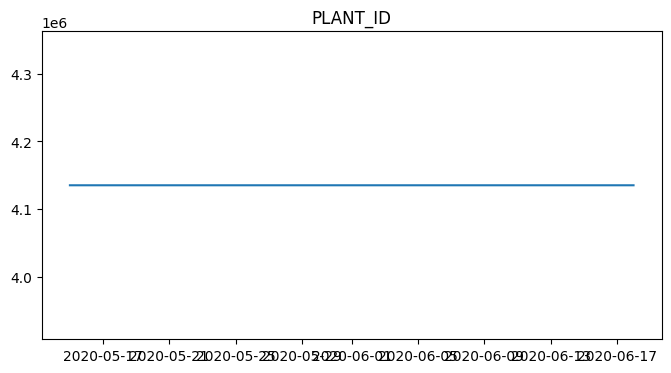

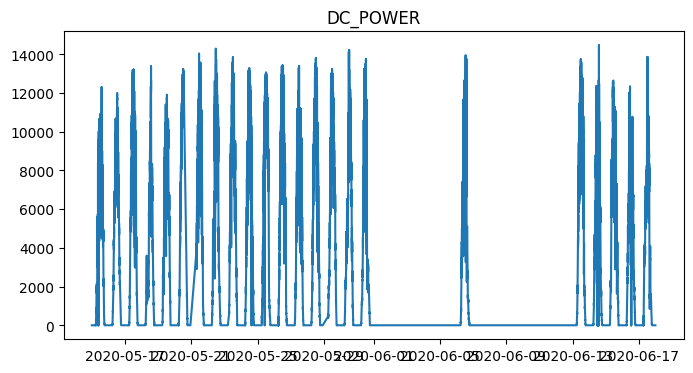

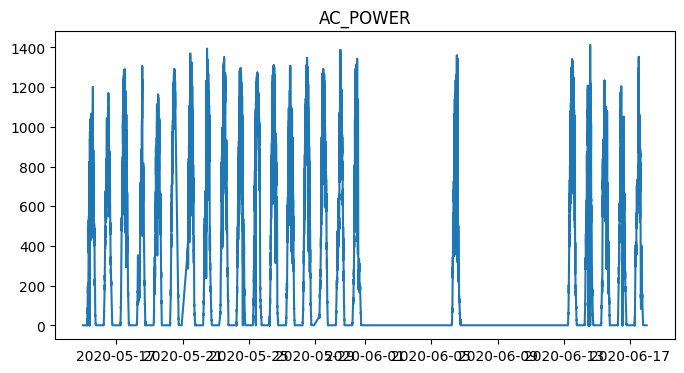

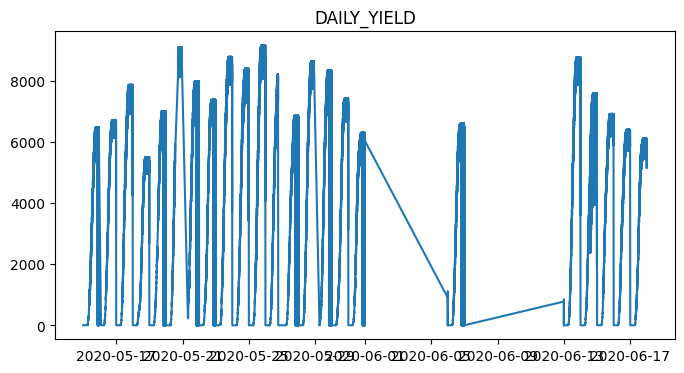

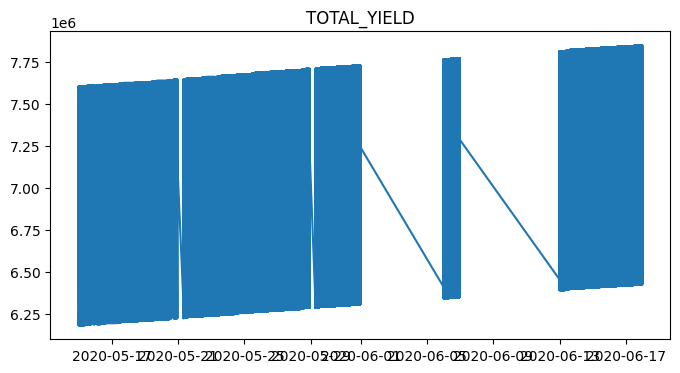

In [74]:
# Time series plots of the entire plant
plot_raw_plant_time_series(plant_1)

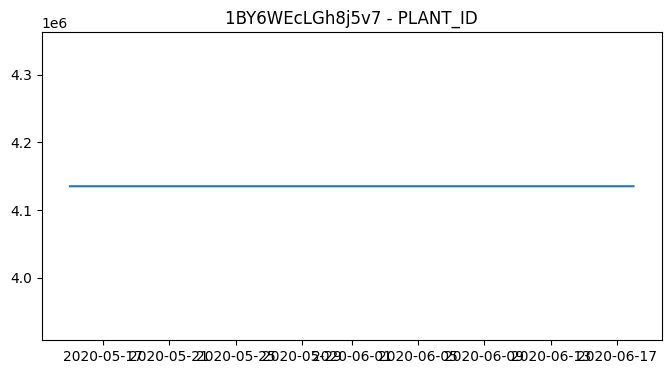

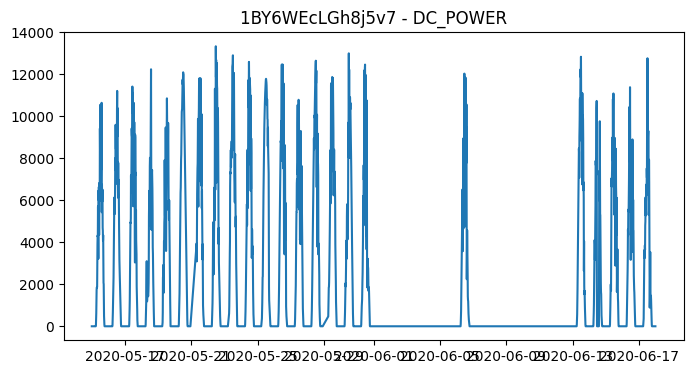

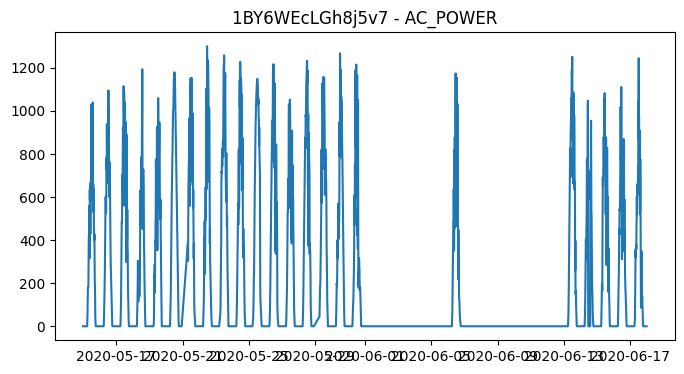

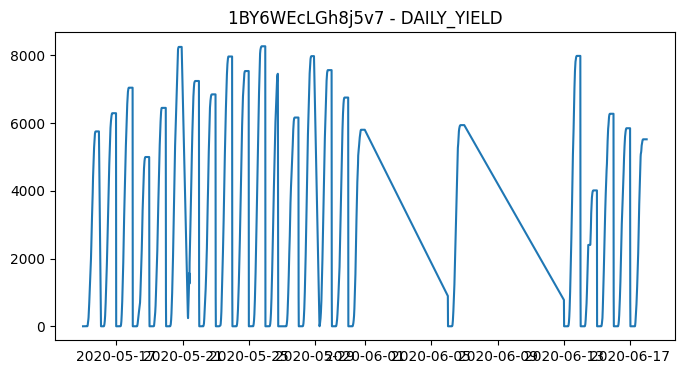

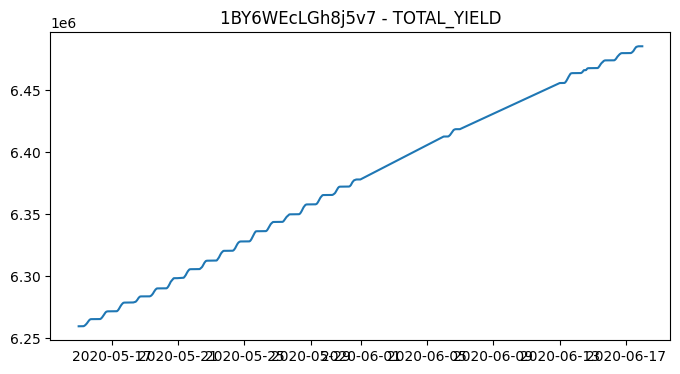

In [75]:
# Time series plots of one invertre after handling DATE_TIME Issues
plot_inverter_raw(inv_1, source_key_1[0])

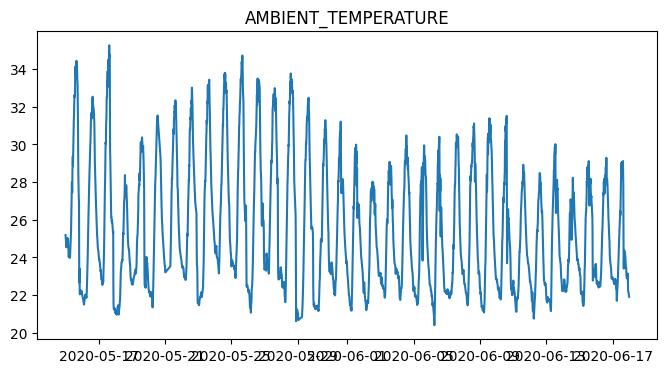

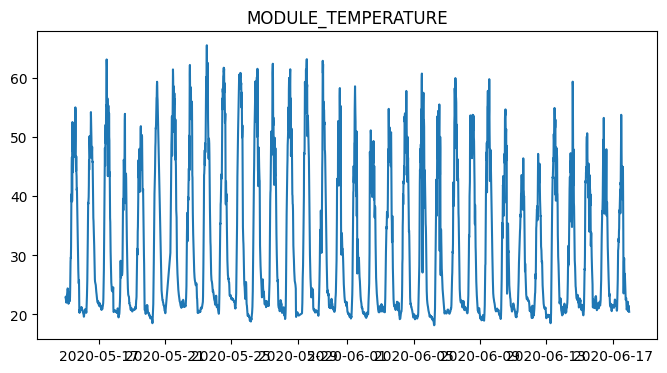

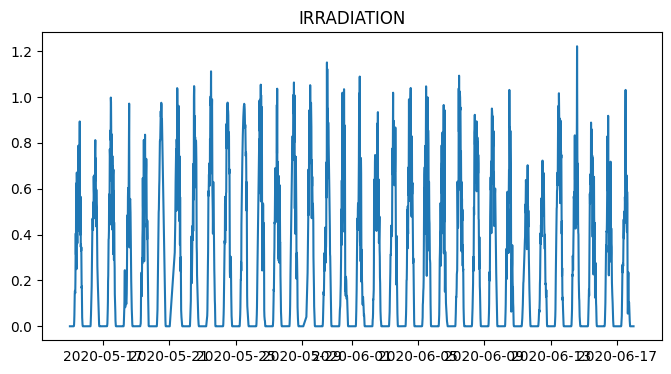

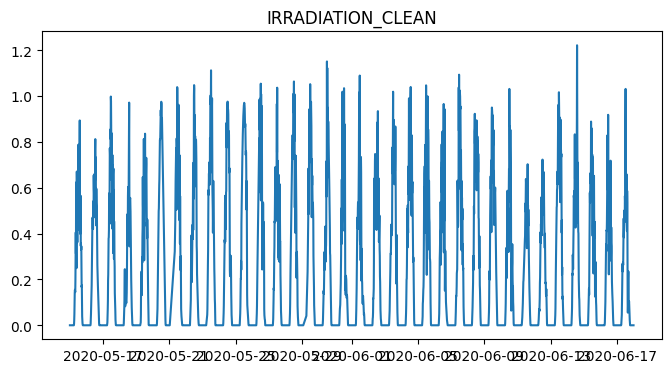

In [76]:
# Time series plots of the weather data before cleaning
plot_weather_time_series(weather_1)

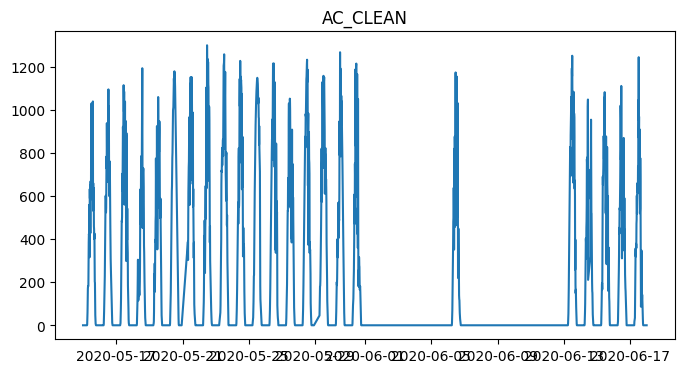

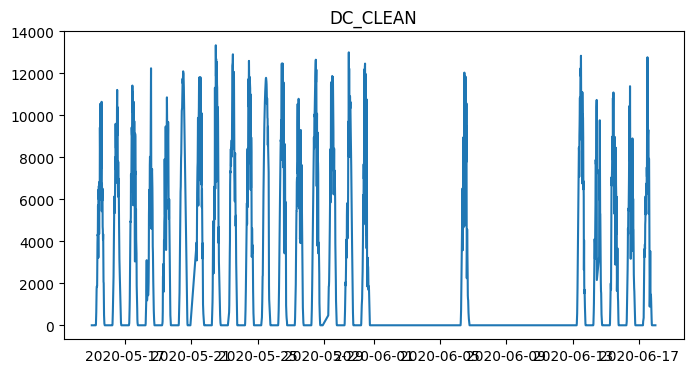

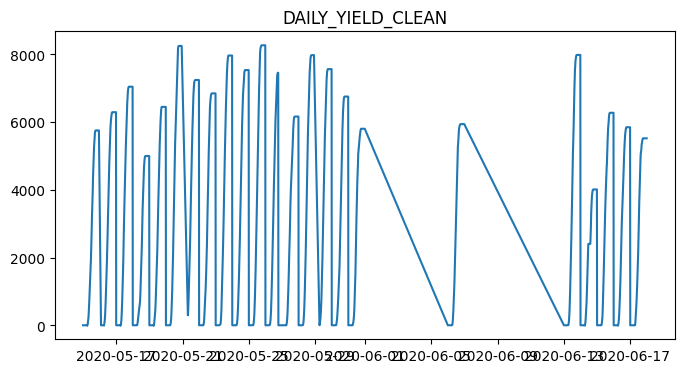

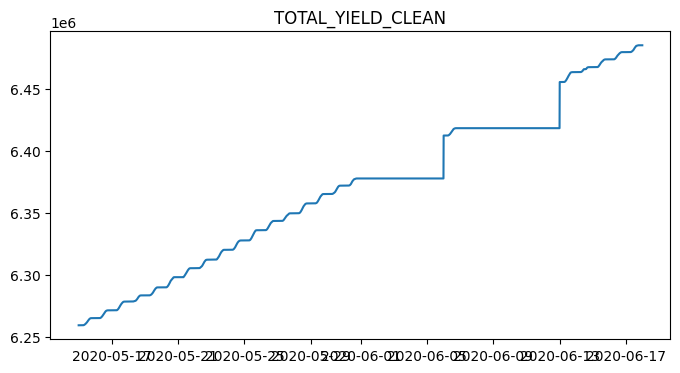

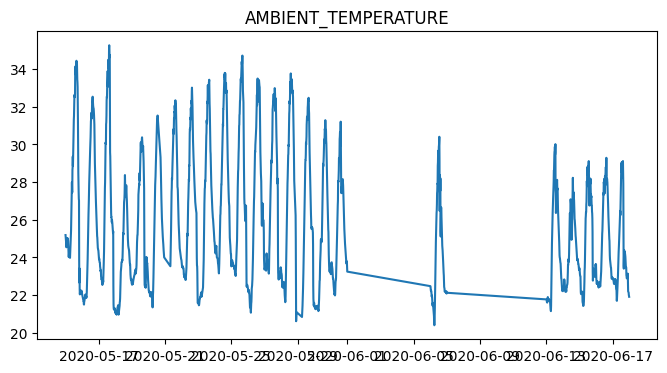

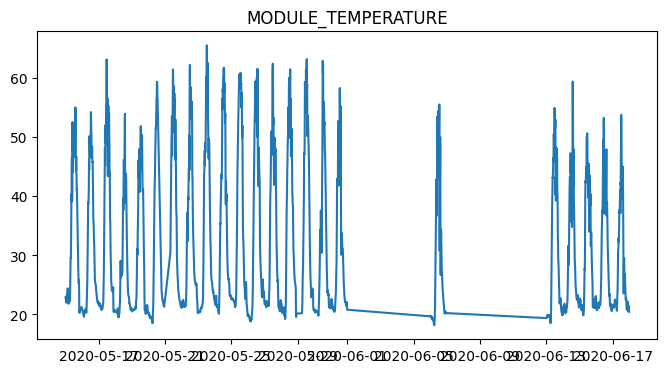

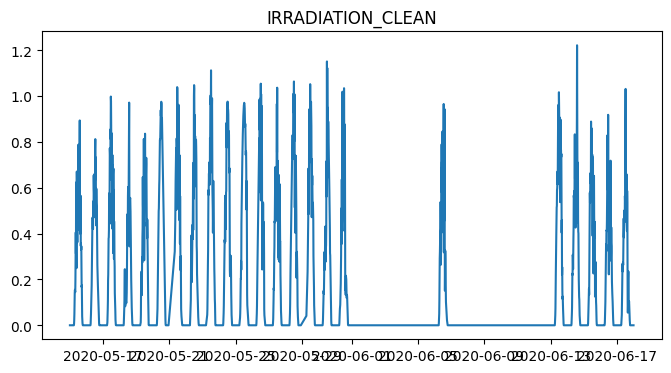

In [77]:
# Time series plots of one inverter after cleaning
plot_clean_inverter_time_series(df_ps1, source_key_1[0])

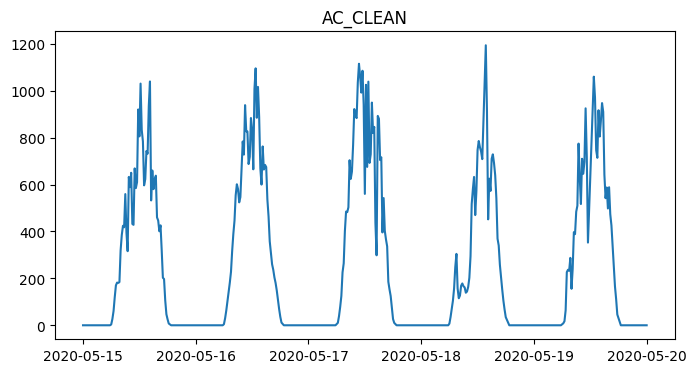

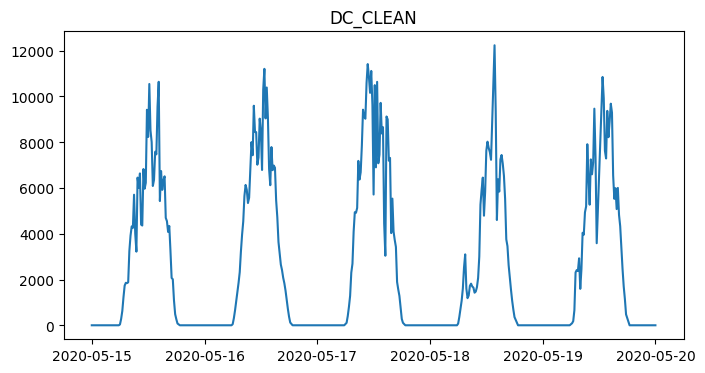

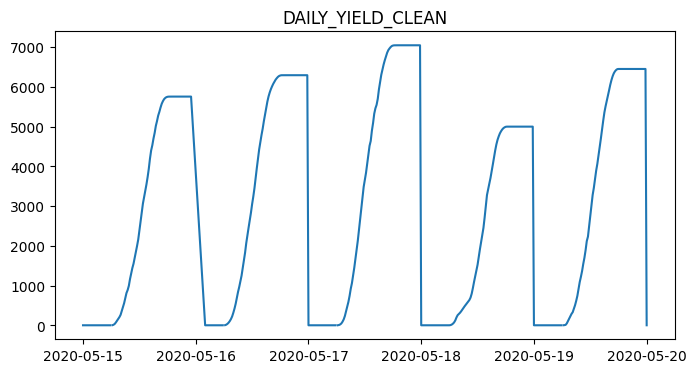

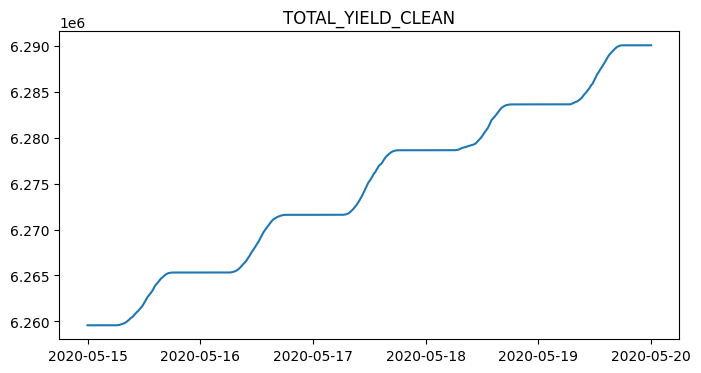

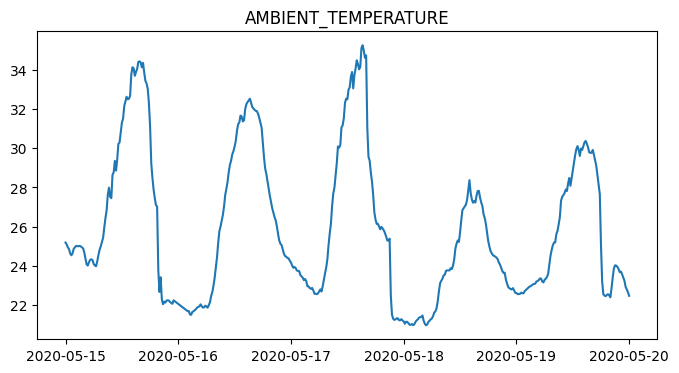

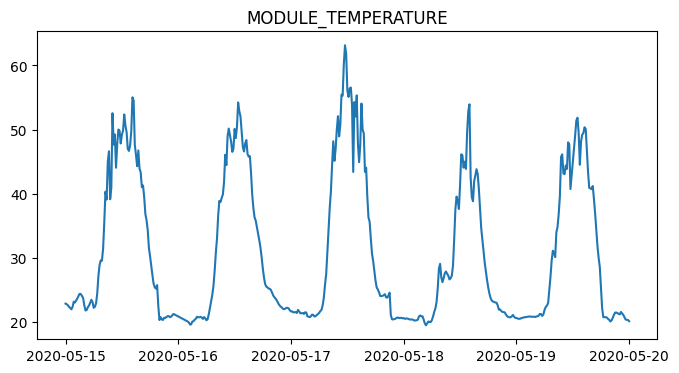

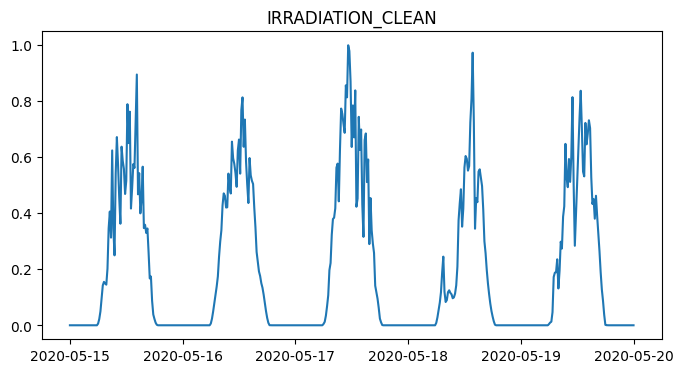

In [78]:
# Zoomed in time series plots of one inverter
plot_zoom_5_days(df_ps1, source_key_1[0])

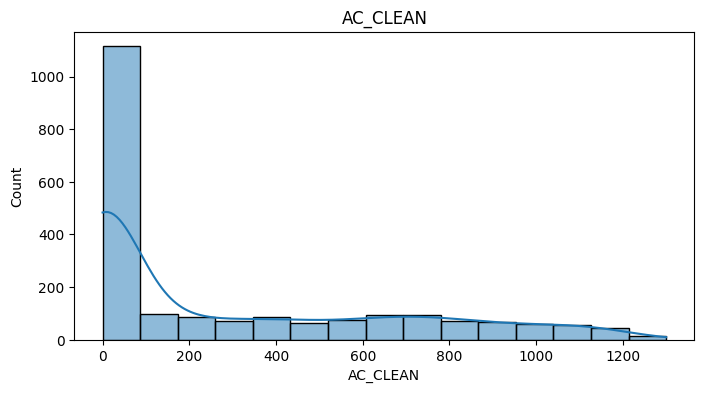

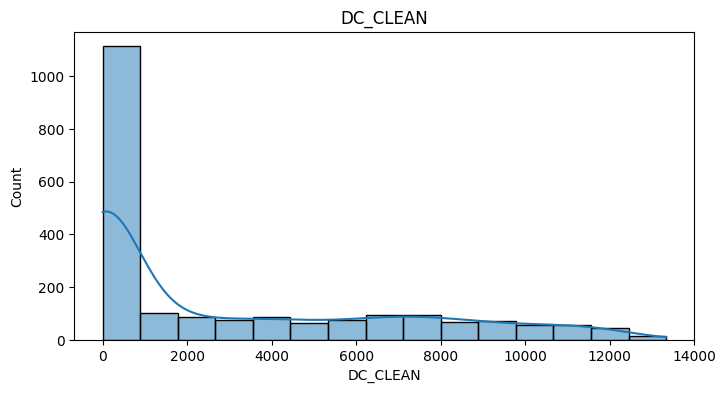

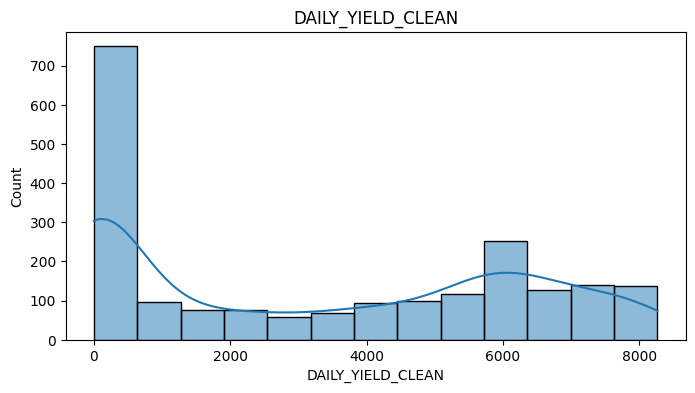

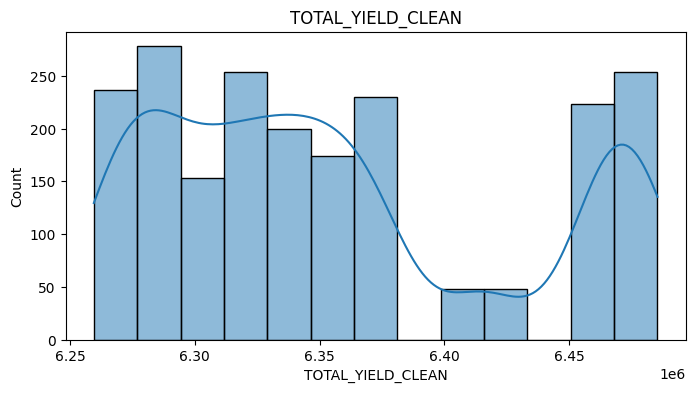

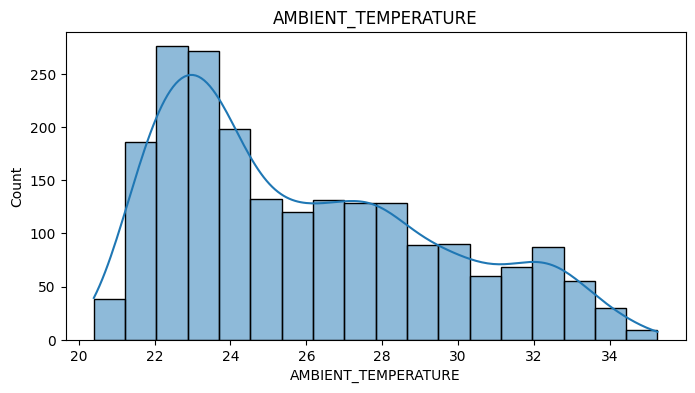

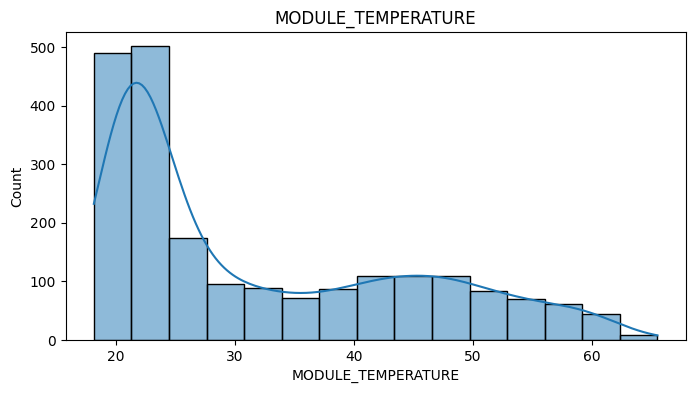

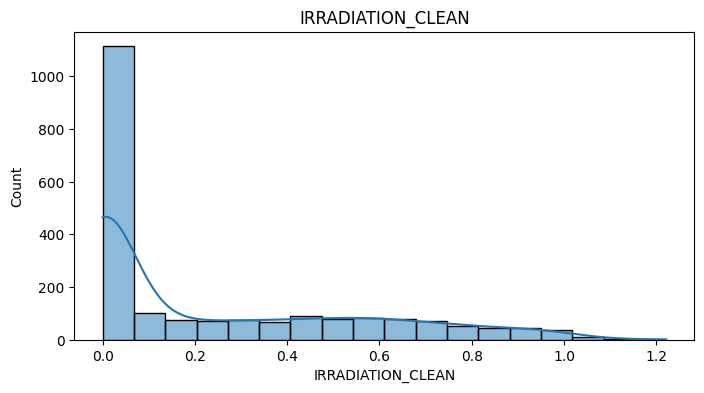

In [79]:
# Histograms of one inverter
plot_histograms_for_inverter(df_ps1, source_key_1[0])


In [80]:
# Similar correlation matrix for every inverter
# for sk , df in df_ps1.items():
#     print('Plant 1 Inverter ' + sk)
#     df = df.drop(columns = ['PLANT_ID','SOURCE_KEY','OPERATING_CONDITION_CLEAN'])
#     print(df.corr())

# Similar correlation matrix for every inverter
for sk, df in df_ps1.items():
    print('Plant 1 Inverter ' + sk)
    df_corr = df.drop(
        columns=['SOURCE_KEY', 'OPERATING_CONDITION_CLEAN'], 
        errors='ignore'
    ).select_dtypes(include=[np.number])
    print(df_corr.corr())



Plant 1 Inverter 1BY6WEcLGh8j5v7
                     AC_CLEAN  DC_CLEAN  DAILY_YIELD_CLEAN  TOTAL_YIELD_CLEAN  \
AC_CLEAN             1.000000  0.999997           0.027537          -0.037555   
DC_CLEAN             0.999997  1.000000           0.027671          -0.037612   
DAILY_YIELD_CLEAN    0.027537  0.027671           1.000000          -0.002139   
TOTAL_YIELD_CLEAN   -0.037555 -0.037612          -0.002139           1.000000   
AMBIENT_TEMPERATURE  0.702965  0.702745           0.458331          -0.189685   
MODULE_TEMPERATURE   0.950480  0.950352           0.157220          -0.078119   
IRRADIATION_CLEAN    0.981429  0.981442           0.023821          -0.028098   

                     AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
AC_CLEAN                        0.702965            0.950480   
DC_CLEAN                        0.702745            0.950352   
DAILY_YIELD_CLEAN               0.458331            0.157220   
TOTAL_YIELD_CLEAN              -0.189685           -0.078119  

In [81]:
# # Sample correlation matrix for one of the inverter
# eg4 = df_ps1[source_key_1[0]].drop(columns = ['PLANT_ID','SOURCE_KEY','OPERATING_CONDITION_CLEAN'])
# eg4.corr()

# Sample correlation matrix for one of the inverters
eg4 = df_ps1[source_key_1[0]].drop(
    columns=['SOURCE_KEY', 'OPERATING_CONDITION_CLEAN'], 
    errors='ignore'
).select_dtypes(include=[np.number])

eg4.corr()


,AC_CLEAN,DC_CLEAN,DAILY_YIELD_CLEAN,TOTAL_YIELD_CLEAN,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION_CLEAN
AC_CLEAN,1.000000,0.999997,0.027537,-0.037555,0.702965,0.950480,0.981429
DC_CLEAN,0.999997,1.000000,0.027671,-0.037612,0.702745,0.950352,0.981442
DAILY_YIELD_CLEAN,0.027537,0.027671,1.000000,-0.002139,0.458331,0.157220,0.023821
TOTAL_YIELD_CLEAN,-0.037555,-0.037612,-0.002139,1.000000,-0.189685,-0.078119,-0.028098
AMBIENT_TEMPERATURE,0.702965,0.702745,0.458331,-0.189685,1.000000,0.841197,0.698838
MODULE_TEMPERATURE,0.950480,0.950352,0.157220,-0.078119,0.841197,1.000000,0.959282
IRRADIATION_CLEAN,0.981429,0.981442,0.023821,-0.028098,0.698838,0.959282,1.000000


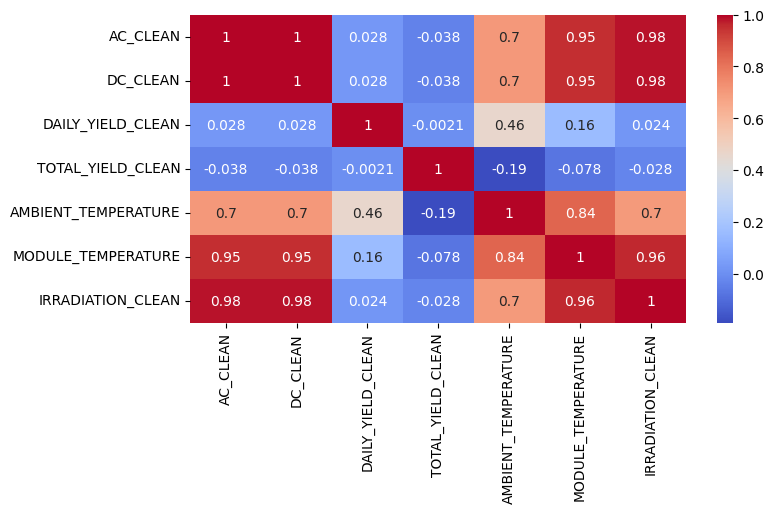

In [82]:
# Find correlation between features of one inverter
plot_correlation_heatmap(df_ps1, source_key_1[0])

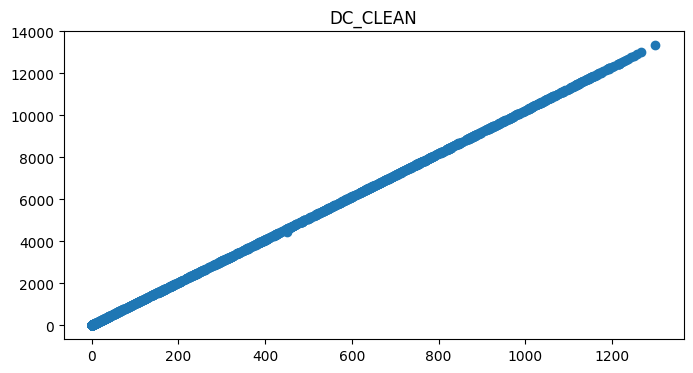

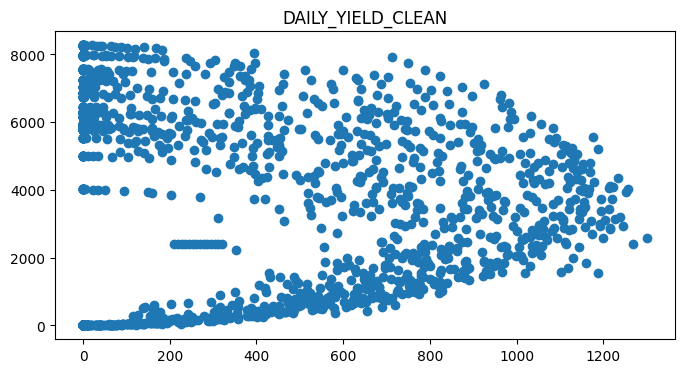

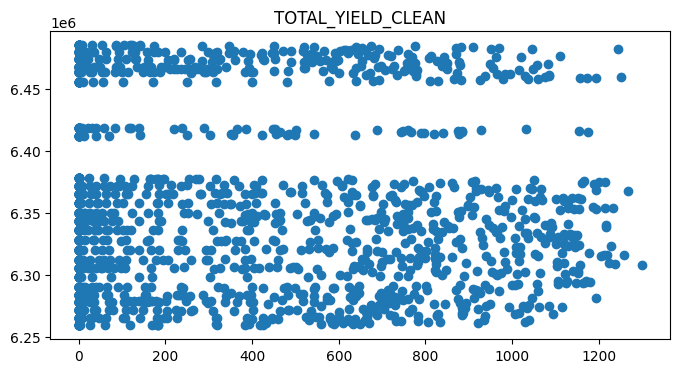

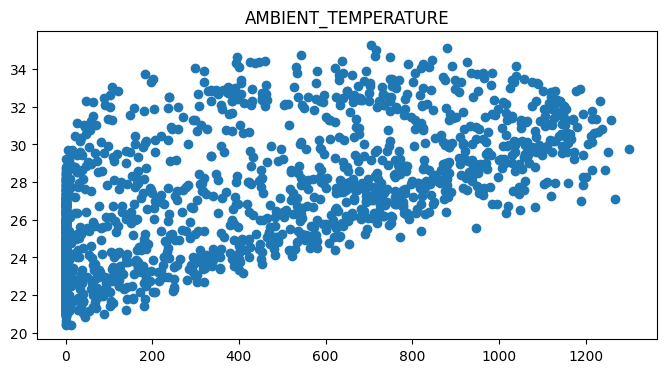

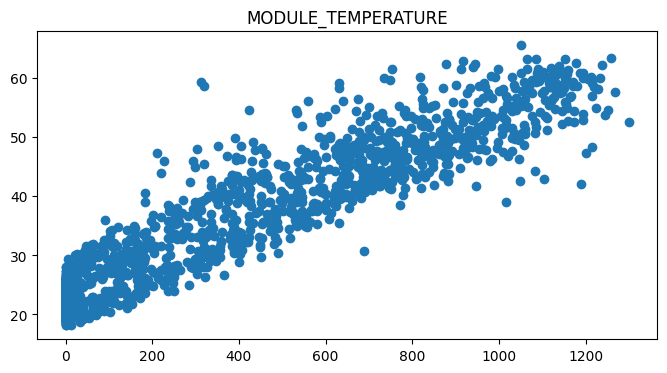

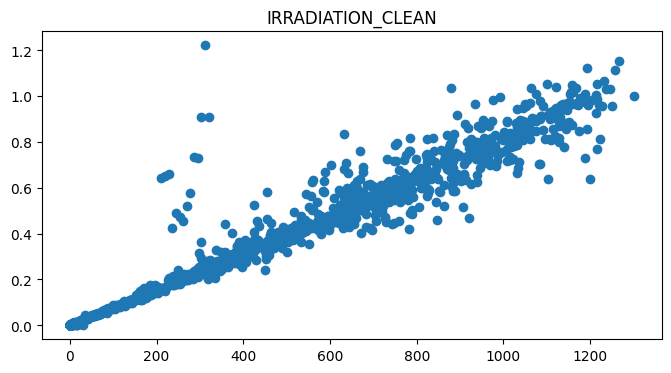

In [83]:
# Scatter plot of AC vs other features to check for outliers
scatter_ac_vs_others(df_ps1, source_key_1[0])

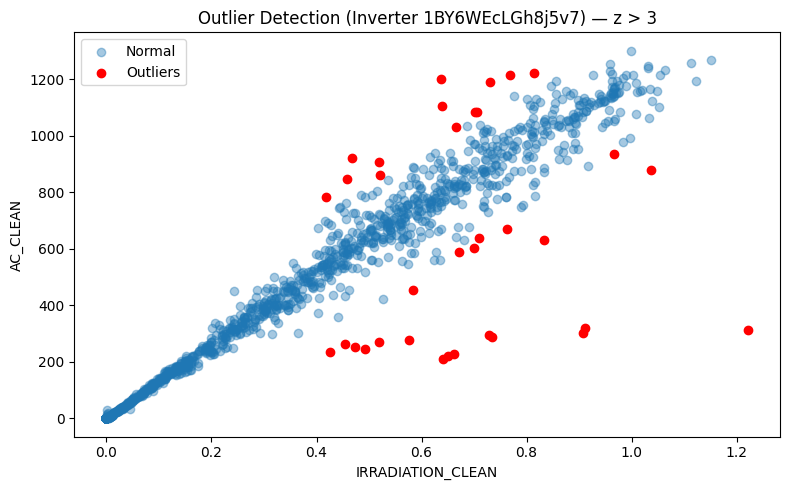

In [84]:
# Identify outliers using regression residuals
plot_outlier_residuals_for_inverter(df_ps1, source_key_1[0])   

#### Based on the correlation analysis:
AC and DC power output is highly correlated with ambient temperature, module temperature and irradiation, thus can be used task 3 and task 6 (regression and LSTM on predicting power output) The operating condition is also correlated with change in irradiation and power output based on the time series plots, thus can be consider as important features for classfication model in task 4.

#### Scaling of features:
Different scalings are suitable for different models, thus require further analysis in later parts.